# Pneumonia Detection Project - Data Preparation

## Pneumonia Detection from Chest X-Ray Images  
### Data Preparation & Exploratory Analysis

This notebook focuses on preparing the chest X-ray dataset for our pneumonia detection project in CS 171.  
We will:
- Load the **Chest X-Ray Images (Pneumonia)** dataset from local folders.
- Apply image transformations such as resizing, normalization, and augmentation.
- Build PyTorch `DataLoader` objects for training, validation, and testing.
- Visually inspect sample images and class distributions.

Authors: **Aye Nyein Kyaw** and **Isiah Ketton**  
Course: **CS 171 – Machine Learning**


- Import PyTorch and `torchvision` utilities.
- Define the paths to the training, validation, and test directories.
- Set up image transformations for preprocessing.

In [43]:
# Import libraries
import os
import torch
import numpy as np
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import datetime

In [9]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

print("Visualization style configured")

Visualization style configured


In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
elif torch.backends.mps.is_available():  # For Apple Silicon Macs
    device = torch.device("mps")
    print("MPS")
else:
    device = torch.device("cpu")
    print("CPU")

MPS


## Dataset Description

We use the **Chest X-Ray Images (Pneumonia)** dataset by Paul Mooney, originally published on Kaggle and sourced from the Guangzhou Women and Children’s Medical Center.

The dataset has three main splits:
- `train/` – used to train the model
- `val/` – used to tune hyperparameters
- `test/` – used to evaluate final performance

Each split contains two classes:
- `NORMAL`
- `PNEUMONIA`

In this project, the dataset is stored locally in the following structure:

```text
data/
  chest_xray/
    train/
      NORMAL/
      PNEUMONIA/
    val/
      NORMAL/
      PNEUMONIA/
    test/
      NORMAL/
      PNEUMONIA/


In [15]:
# Define data directories 
BASE_DIR = Path("data/chest_xray")

train_dir = BASE_DIR / "train"
val_dir = BASE_DIR / "val"
test_dir = BASE_DIR / "test"

# Display paths
print("Dataset paths:")
print(f"Training directory:   {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory:       {test_dir}")

Dataset paths:
Training directory:   data/chest_xray/train
Validation directory: data/chest_xray/val
Test directory:       data/chest_xray/test


## Count Images in Each Class

In [16]:
def count_images_in_directory(directory_path):
    """Count images in each class directory."""
    counts = {}
    
    if directory_path.exists():
        # List all subdirectories (should be NORMAL and PNEUMONIA)
        for class_dir in directory_path.iterdir():
            if class_dir.is_dir():
                class_name = class_dir.name
                
                # Count image files (supports .jpeg, .jpg, .png)
                image_extensions = ['.jpeg', '.jpg', '.png', '.JPEG', '.JPG', '.PNG']
                image_count = 0
                
                for ext in image_extensions:
                    image_count += len(list(class_dir.glob(f"*{ext}")))
                
                counts[class_name] = image_count
    
    return counts

print("Counting images in each directory...\n")

# Count for each split
dataset_stats = {}

for split_dir, split_name in [(train_dir, "Train"), (val_dir, "Validation"), (test_dir, "Test")]:
    counts = count_images_in_directory(split_dir)
    
    if counts:
        normal_count = counts.get("NORMAL", 0)
        pneumonia_count = counts.get("PNEUMONIA", 0)
        total = normal_count + pneumonia_count
        
        dataset_stats[split_name] = {
            "NORMAL": normal_count,
            "PNEUMONIA": pneumonia_count,
            "Total": total
        }

        print(f"{split_name} Set:")
        print(f"  NORMAL images:    {normal_count:>5}")
        print(f"  PNEUMONIA images: {pneumonia_count:>5}")
        print(f"  TOTAL images:     {total:>5}")
        
        if normal_count > 0:
            ratio = pneumonia_count / normal_count
            print(f"  Ratio (PNEUMONIA:NORMAL): {ratio:.2f}:1")
        print()

Counting images in each directory...

Train Set:
  NORMAL images:     1341
  PNEUMONIA images:  3875
  TOTAL images:      5216
  Ratio (PNEUMONIA:NORMAL): 2.89:1

Validation Set:
  NORMAL images:        8
  PNEUMONIA images:     8
  TOTAL images:        16
  Ratio (PNEUMONIA:NORMAL): 1.00:1

Test Set:
  NORMAL images:      234
  PNEUMONIA images:   390
  TOTAL images:       624
  Ratio (PNEUMONIA:NORMAL): 1.67:1



## Visualize Class Distribution

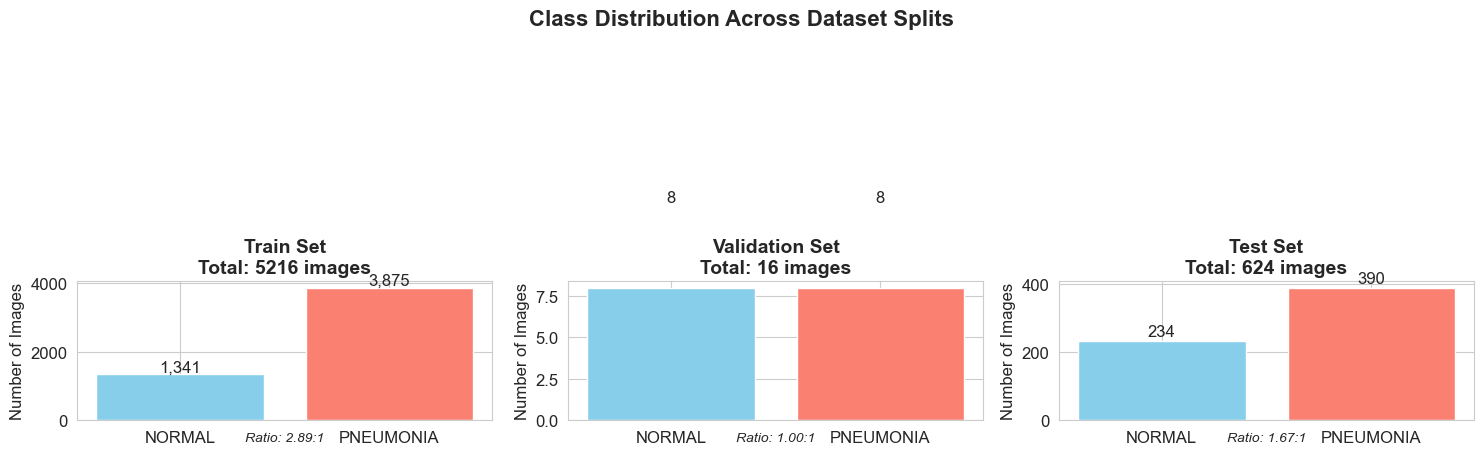

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Colors for the bars
colors = {'NORMAL': 'skyblue', 'PNEUMONIA': 'salmon'}

for idx, (split_name, stats) in enumerate(dataset_stats.items()):
    # Get counts
    normal = stats['NORMAL']
    pneumonia = stats['PNEUMONIA']
    
    # Create bars
    bars = axes[idx].bar(['NORMAL', 'PNEUMONIA'], 
                        [normal, pneumonia],
                        color=[colors['NORMAL'], colors['PNEUMONIA']])
    
    # Add titles and labels
    axes[idx].set_title(f'{split_name} Set\nTotal: {stats["Total"]} images')
    axes[idx].set_ylabel('Number of Images')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 5,
                      f'{int(height):,}', ha='center', va='bottom')
    
    # Add ratio text below
    if normal > 0:
        ratio = pneumonia / normal
        axes[idx].text(0.5, -0.15, f'Ratio: {ratio:.2f}:1', 
                      ha='center', transform=axes[idx].transAxes,
                      fontsize=10, style='italic')

plt.suptitle('Class Distribution Across Dataset Splits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Number of training images: 5216
Classes: ['NORMAL', 'PNEUMONIA']


## Visualizing Sample Training Images

To sanity-check that:
- The dataset is loaded correctly,
- Labels are mapped correctly to `NORMAL` and `PNEUMONIA`,
- Transforms are applied as expected,

we display a small batch of sample images from the training set along with their class labels.
This helps us confirm that the data pipeline is working before moving on to model training.


Displaying sample images from training set...


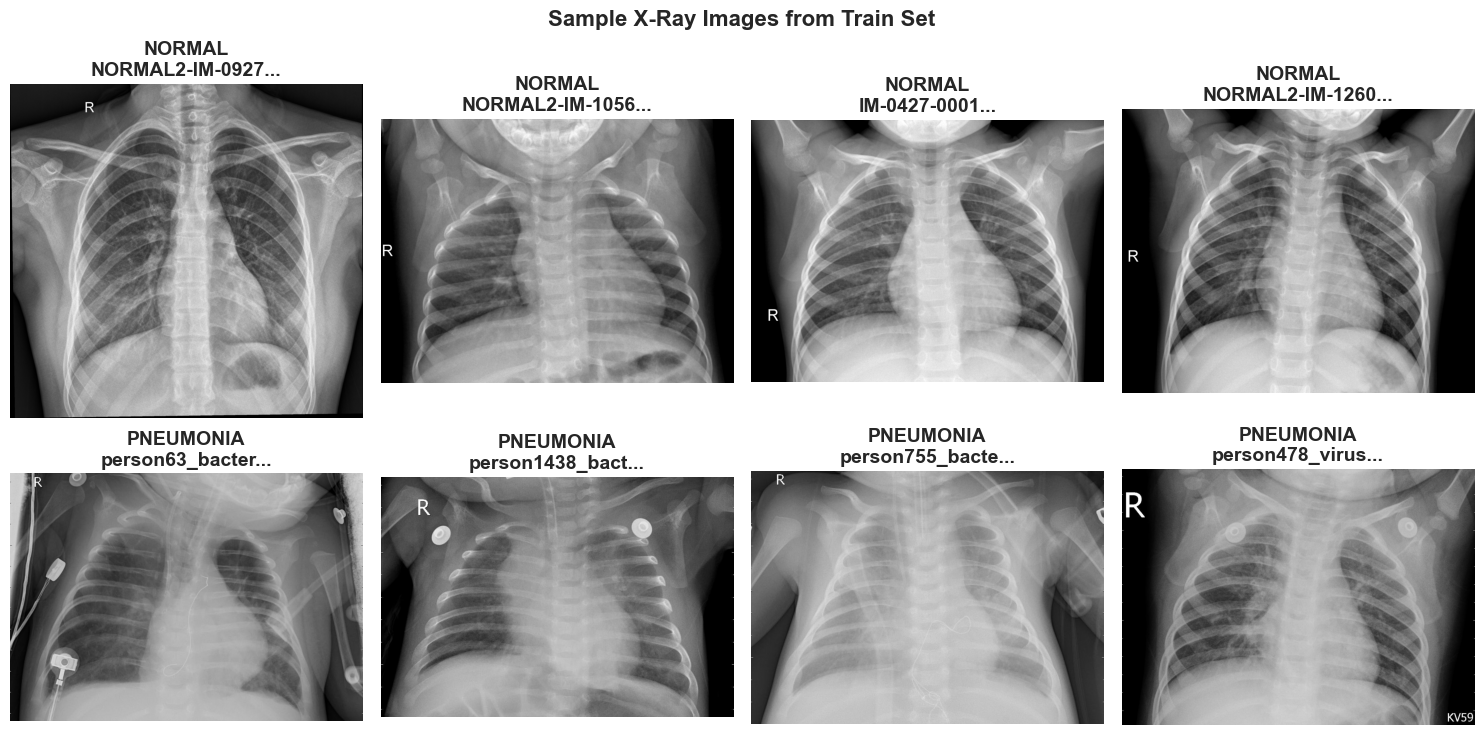

In [20]:
def display_sample_images(directory_path, num_samples=4):
    """Display sample images from each class."""
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for row_idx, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        class_path = directory_path / class_name
        
        if not class_path.exists():
            print(f"  Skipping {class_name} - directory not found")
            continue
        
        # Get list of image files
        image_files = []
        for ext in ['.jpeg', '.jpg', '.png', '.JPEG', '.JPG', '.PNG']:
            image_files.extend(list(class_path.glob(f"*{ext}")))
        
        if not image_files:
            print(f"  No images found in {class_path}")
            continue
        
        # Take first 'num_samples' images
        sample_files = image_files[:num_samples]
        
        for col_idx, img_path in enumerate(sample_files):
            try:
                # Open and display image
                img = Image.open(img_path)
                
                ax = axes[row_idx, col_idx]
                ax.imshow(img, cmap='gray')
                ax.set_title(f'{class_name}\n{img_path.stem[:15]}...')
                ax.axis('off')
                
            except Exception as e:
                print(f"  Error loading {img_path}: {e}")
                axes[row_idx, col_idx].axis('off')
    
    plt.suptitle(f'Sample X-Ray Images from {directory_path.name.title()} Set', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display samples from training set
print("Displaying sample images from training set...")
display_sample_images(train_dir, num_samples=4)

## Define Image Transformations

We need to preprocess images before feeding them to our CNN.

**Key decisions:**
1. **Image size**: 224x224 pixels (standard for CNNs)
2. **Color channels**: Convert grayscale to 3-channel (required by many models)
3. **Normalization**: Scale pixel values to [-1, 1] range
4. **Augmentation**: Only for training set (prevents overfitting)


In [21]:
print("Defining image transformations...")

# Constants
IMAGE_SIZE = 224  # Standard size for many CNN architectures

Defining image transformations...


## TRANSFORM 1: For Validation and Testing

No augmentation - we want to evaluate on original images

In [23]:
basic_transform = transforms.Compose([
    # 1. Resize all images to same size
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    
    # 2. Convert grayscale to 3-channel
    # Why? Many pretrained models expect 3 channels (RGB)
    transforms.Grayscale(num_output_channels=3),
    
    # 3. Convert PIL Image to PyTorch Tensor
    transforms.ToTensor(),
    
    # 4. Normalize pixel values
    # Mean=0.5, Std=0.5 changes range from [0,1] to [-1,1]
    # This helps with training stability
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                        std=[0.5, 0.5, 0.5])
])


## TRANSFORM 2: For Training (WITH AUGMENTATION
Add random transformations to create more variety
This helps prevent overfitting

In [26]:
augmented_transform = transforms.Compose([
    # 1. Resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    
    # 2. Convert to 3-channel
    transforms.Grayscale(num_output_channels=3),
    
    #  DATA AUGMENTATION 
    # 3. Random horizontal flip (50% chance)
    # Why? X-rays can be taken from different orientations
    transforms.RandomHorizontalFlip(p=0.5),
    
    # 4. Random rotation (±10 degrees)
    # Why? Small variations in patient positioning
    transforms.RandomRotation(degrees=10),
    
    # 5. Random brightness/contrast adjustment
    # Why? X-rays can have different exposure levels
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    
    # 6. Convert to tensor
    transforms.ToTensor(),
    
    # 7. Normalize
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                        std=[0.5, 0.5, 0.5])
])

print("Transformations defined")
print(f"\nImage size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Training transforms include: RandomFlip, Rotation, ColorJitter")
print(f"Validation/Test transforms: Basic preprocessing only")

Transformations defined

Image size: 224x224
Training transforms include: RandomFlip, Rotation, ColorJitter
Validation/Test transforms: Basic preprocessing only


## Augmentation Effects

Demonstrating augmentation on: NORMAL2-IM-0927-0001.jpeg


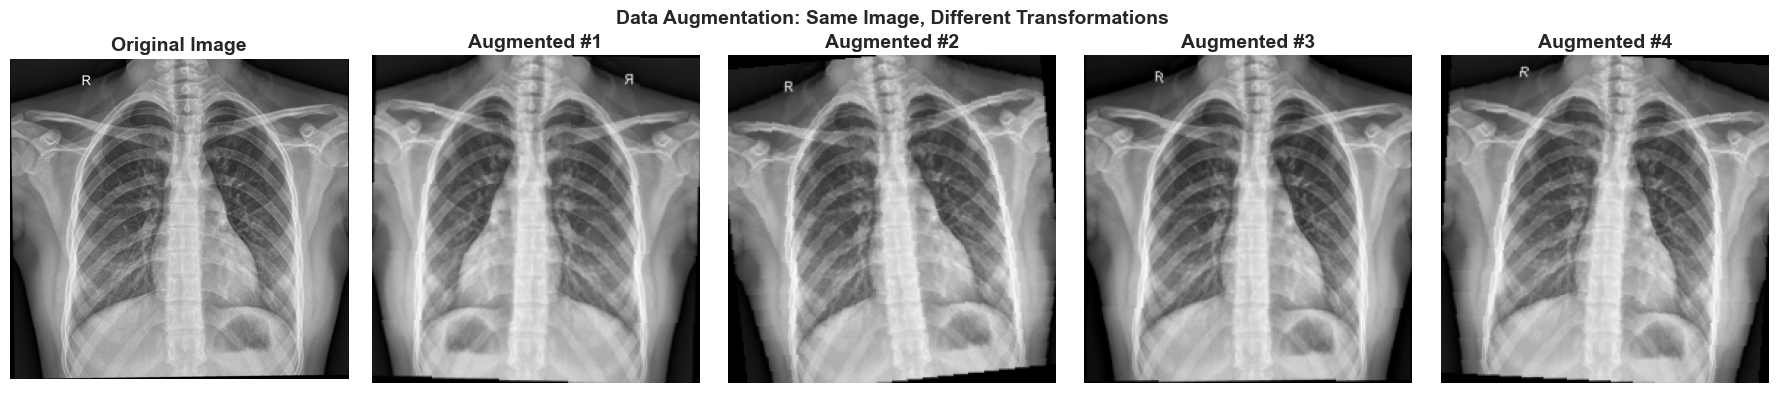

In [33]:
def show_augmentation_demo(image_path):
    """Show how augmentation transforms an image."""
    
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    # Load original image
    original_img = Image.open(image_path).convert('RGB')
    
    # Create figure
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    
    # Show original
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Show 4 different augmentations of the same image
    for i in range(4):
        # Apply augmented transform
        augmented_img = augmented_transform(original_img)
        
        # Convert tensor back to display format
        img_display = augmented_img.numpy().transpose((1, 2, 0))
        img_display = img_display * 0.5 + 0.5  # Unnormalize
        img_display = np.clip(img_display, 0, 1)
        
        # Display
        axes[i+1].imshow(img_display[:, :, 0], cmap='gray')
        axes[i+1].set_title(f'Augmented #{i+1}')
        axes[i+1].axis('off')
    
    plt.suptitle('Data Augmentation: Same Image, Different Transformations', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Try to find an example image
example_image = None
normal_images = list((train_dir / "NORMAL").glob("*.jpeg"))
if normal_images:
    example_image = str(normal_images[0])
    print(f"Demonstrating augmentation on: {normal_images[0].name}")
    show_augmentation_demo(example_image)
else:
    print("No example image found for augmentation demo")


## Load Datasets with PyTorch

PyTorch's `ImageFolder` automatically:
- Loads images from folder structure
- Assigns labels based on folder names
- Applies transformations on-the-fly

In [35]:
print("Loading datasets...")

try:
    # 1. TRAINING DATASET (with augmentation)
    train_dataset = datasets.ImageFolder(
        root=str(train_dir),
        transform=augmented_transform
    )
    print(f"Training dataset loaded: {len(train_dataset)} images")
    


    
    # 2. VALIDATION DATASET (no augmentation)

    val_dataset = datasets.ImageFolder(
        root=str(val_dir),
        transform=basic_transform
    )
    print(f"Validation dataset loaded: {len(val_dataset)} images")


    

    # 3. TEST DATASET (no augmentation)

    test_dataset = datasets.ImageFolder(
        root=str(test_dir),
        transform=basic_transform
    )
    print(f"Test dataset loaded: {len(test_dataset)} images")




    
    # 4. DISPLAY CLASS INFORMATION
    print("\n=== CLASS INFORMATION ===")
    print(f"Classes: {train_dataset.classes}")
    print(f"Class to index mapping: {train_dataset.class_to_idx}")
    
    # Show example of how classes are mapped
    print("\nExample: 'NORMAL' ", train_dataset.class_to_idx['NORMAL'])
    print("Example: 'PNEUMONIA' ", train_dataset.class_to_idx['PNEUMONIA'])



    
except Exception as e:
    print(f"\n ERROR loading datasets: {e}")
    print("\nCommon issues:")
    print("1. Dataset not downloaded")
    print("2. Incorrect folder structure")
    print("3. No images in directories")
    raise

Loading datasets...
Training dataset loaded: 5216 images
Validation dataset loaded: 16 images
Test dataset loaded: 624 images

=== CLASS INFORMATION ===
Classes: ['NORMAL', 'PNEUMONIA']
Class to index mapping: {'NORMAL': 0, 'PNEUMONIA': 1}

Example: 'NORMAL'  0
Example: 'PNEUMONIA'  1


## Create DataLoader Objects

`DataLoader` handles:
- Batching (grouping images together)
- Shuffling (mixing up training data)
- Parallel loading (using multiple CPU cores)

In [36]:
print("Creating DataLoader objects...")


# SET BATCH SIZE
# Larger batch = faster training, but more memory
# Smaller batch = more stable training, but slower
BATCH_SIZE = 32
print(f"Batch size: {BATCH_SIZE}")


# 1. TRAINING DATALOADER

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # VERY IMPORTANT: Shuffle training data
    num_workers=2,         # Use 2 CPU cores for loading
    pin_memory=True        # Faster data transfer to GPU
)
print(f"Training DataLoader created: {len(train_loader)} batches")


# 2. VALIDATION DATALOADER
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # Don't shuffle validation data
    num_workers=2,
    pin_memory=True
)
print(f"Validation DataLoader created: {len(val_loader)} batches")


# 3. TEST DATALOADER
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # Don't shuffle test data
    num_workers=2,
    pin_memory=True
)
print(f"Test DataLoader created: {len(test_loader)} batches")


# SUMMARY
print("\n=== SUMMARY ===")
print(f"Total training images:   {len(train_dataset):>6}")
print(f"Total validation images: {len(val_dataset):>6}")
print(f"Total test images:       {len(test_dataset):>6}")
print(f"\nTraining batches:   {len(train_loader)} (×{BATCH_SIZE} images each)")
print(f"Validation batches: {len(val_loader)} (×{BATCH_SIZE} images each)")
print(f"Test batches:       {len(test_loader)} (×{BATCH_SIZE} images each)")

Creating DataLoader objects...
Batch size: 32
Training DataLoader created: 163 batches
Validation DataLoader created: 1 batches
Test DataLoader created: 20 batches

=== SUMMARY ===
Total training images:     5216
Total validation images:     16
Total test images:          624

Training batches:   163 (×32 images each)
Validation batches: 1 (×32 images each)
Test batches:       20 (×32 images each)


## Visualize training batch


Visualizing a training batch...
Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


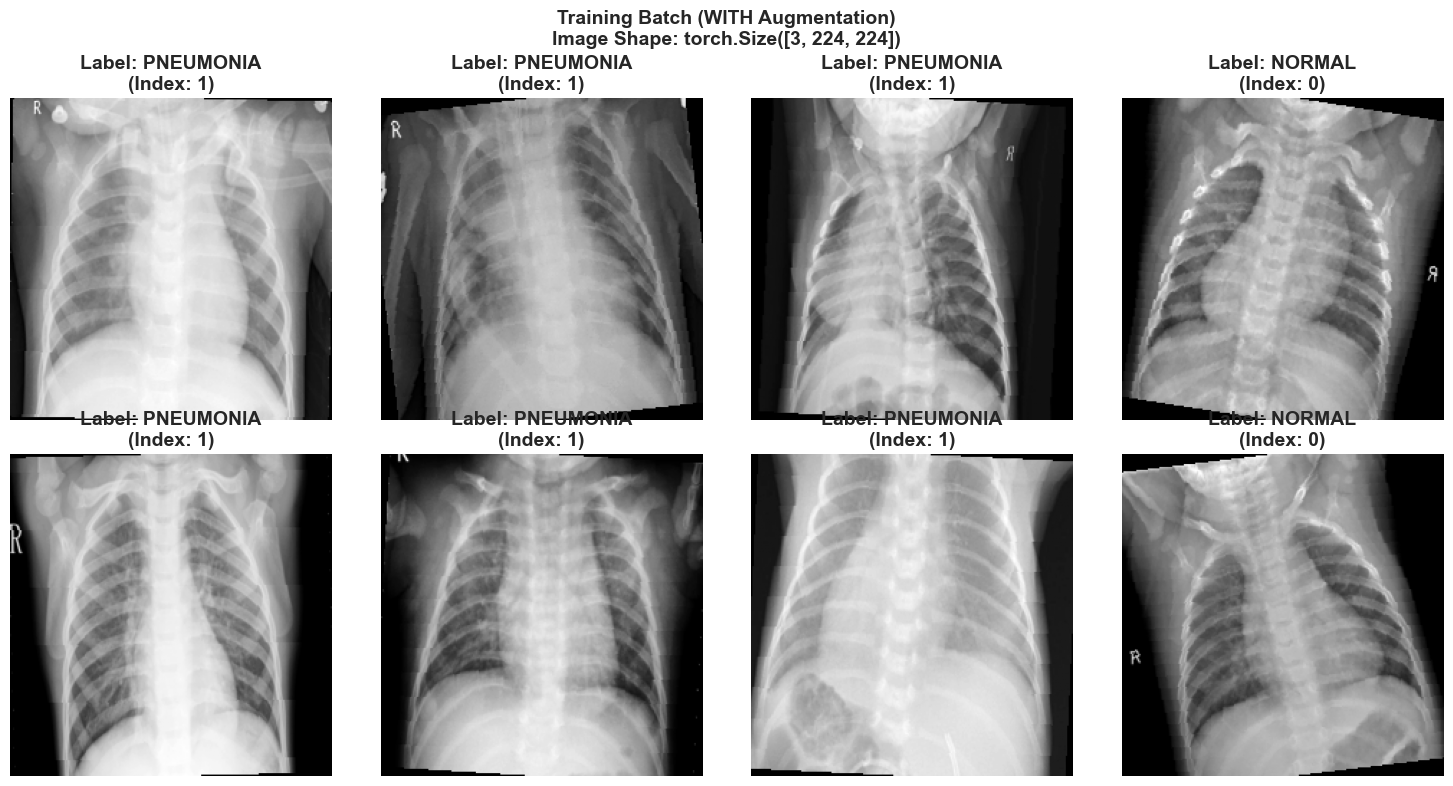


Label distribution in this batch:
  NORMAL: 8 images
  PNEUMONIA: 24 images

Visualizing a validation batch...
Batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


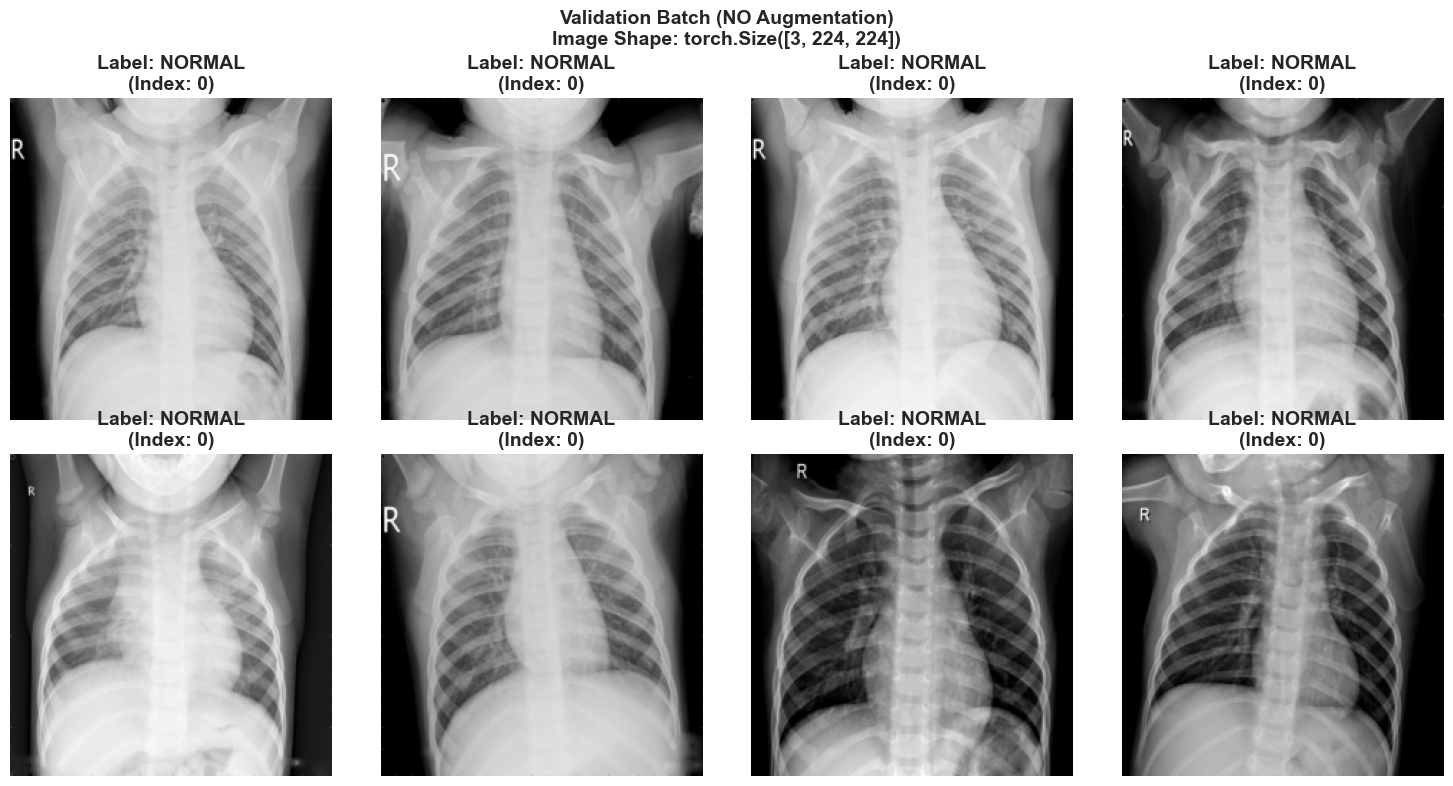


Label distribution in this batch:
  NORMAL: 8 images
  PNEUMONIA: 8 images


In [38]:
def visualize_data_batch(loader, title="Data Batch"):
    """Display a batch of images with labels."""
    
    # Get one batch from the DataLoader
    try:
        images, labels = next(iter(loader))
    except StopIteration:
        print("DataLoader is empty!")
        return
    
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Determine how many images to display (max 8)
    num_images = min(8, len(images))
    
    # Calculate grid size
    grid_cols = 4
    grid_rows = (num_images + grid_cols - 1) // grid_cols
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 4*grid_rows))
    axes = axes.ravel() if grid_rows > 1 else [axes]
    
    for i in range(num_images):
        # Get image and label
        img_tensor = images[i]
        label_idx = labels[i].item()
        
        # Convert tensor back to image for display
        # 1. Move from (C, H, W) to (H, W, C)
        img_np = img_tensor.numpy().transpose((1, 2, 0))
        
        # 2. Unnormalize: [-1, 1] → [0, 1]
        img_np = img_np * 0.5 + 0.5
        
        # 3. Clip to valid range
        img_np = np.clip(img_np, 0, 1)
        
        # 4. Display (use first channel since all are same after Grayscale)
        axes[i].imshow(img_np[:, :, 0], cmap='gray')
        
        # Get class name from label index
        class_name = train_dataset.classes[label_idx]
        
        axes[i].set_title(f'Label: {class_name}\n(Index: {label_idx})')
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'{title}\nImage Shape: {img_tensor.shape}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Count labels in this batch
    unique_labels, counts = np.unique(labels.numpy(), return_counts=True)
    print("\nLabel distribution in this batch:")
    for label_idx, count in zip(unique_labels, counts):
        class_name = train_dataset.classes[label_idx]
        print(f"  {class_name}: {count} images")

# Visualize training batch
print("\nVisualizing a training batch...")
visualize_data_batch(train_loader, title="Training Batch (WITH Augmentation)")

# Visualize validation batch
print("\nVisualizing a validation batch...")
visualize_data_batch(val_loader, title="Validation Batch (NO Augmentation)")


## Check for Class Imbalance Issue 
(medical datasets often have imbalanced classes)

In [39]:
print("=== CLASS IMBALANCE ANALYSIS ===\n")

# Get counts from our loaded dataset
train_counts = dataset_stats.get("Train", {})
normal_count = train_counts.get("NORMAL", 0)
pneumonia_count = train_counts.get("PNEUMONIA", 0)

if normal_count > 0 and pneumonia_count > 0:
    imbalance_ratio = pneumonia_count / normal_count
    
    print(f"Training set has:")
    print(f"  {normal_count:,} NORMAL images")
    print(f"  {pneumonia_count:,} PNEUMONIA images")
    print(f"  Ratio: {imbalance_ratio:.2f}:1 (PNEUMONIA:NORMAL)")
    
    print("\n Imbalance Assessment:")
    if imbalance_ratio > 3:
        print("    SEVERE IMBALANCE DETECTED!")
        print("  The model may become biased toward PNEUMONIA class.")
        print("  Consider using class weights in your loss function.")
    elif imbalance_ratio > 2:
        print("    MODERATE IMBALANCE DETECTED")
        print("  The model might need careful tuning.")
    elif imbalance_ratio > 1.5:
        print("    MILD IMBALANCE")
        print("  Usually manageable with good augmentation.")
    else:
        print("   RELATIVELY BALANCED")
        print("  Good for training!")
else:
    print("Could not calculate imbalance ratio.")

=== CLASS IMBALANCE ANALYSIS ===

Training set has:
  1,341 NORMAL images
  3,875 PNEUMONIA images
  Ratio: 2.89:1 (PNEUMONIA:NORMAL)

 Imbalance Assessment:
    MODERATE IMBALANCE DETECTED
  The model might need careful tuning.


## Save Preprocessing Information

In [45]:
# Create a dictionary with all preprocessing info
preprocessing_info = {
    'project': 'Pneumonia Detection from Chest X-Rays',
    'author': 'Aye Nyein Kyaw',
    'date': str(datetime.now()),
    
    'image_settings': {
        'size': IMAGE_SIZE,
        'channels': 3,
        'normalization': {'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5]}
    },
    
    'data_settings': {
        'batch_size': BATCH_SIZE,
        'train_augmentation': ['RandomHorizontalFlip', 'RandomRotation', 'ColorJitter'],
        'dataset_sizes': {
            'train': len(train_dataset),
            'validation': len(val_dataset),
            'test': len(test_dataset)
        }
    },
    
    'class_info': {
        'classes': train_dataset.classes,
        'class_to_idx': train_dataset.class_to_idx,
        'training_distribution': dataset_stats.get("Train", {})
    },
    
    'paths': {
        'train_dir': str(train_dir),
        'val_dir': str(val_dir),
        'test_dir': str(test_dir)
    }
}

# Save to JSON file
import json
with open('preprocessing_config.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print("Preprocessing configuration saved to 'preprocessing_config.json'")
print("\nYou can load this later with:")
print("import json")
print("with open('preprocessing_config.json', 'r') as f:")
print("    config = json.load(f)")


Preprocessing configuration saved to 'preprocessing_config.json'

You can load this later with:
import json
with open('preprocessing_config.json', 'r') as f:
    config = json.load(f)


## Final Verification

In [47]:
print("=" * 60)
print("FINAL VERIFICATION")
print("=" * 60)

checks_passed = 0
total_checks = 5

# Check 1: DataLoaders can iterate
print("\n1. Testing DataLoader iteration...")
try:
    # Test each DataLoader
    for name, loader in [("Train", train_loader), 
                        ("Validation", val_loader), 
                        ("Test", test_loader)]:
        test_batch = next(iter(loader))
        print(f"   {name} DataLoader works")
    checks_passed += 1
except Exception as e:
    print(f"   Error: {e}")

# Check 2: Batch shapes are correct
print("\n2. Checking batch shapes...")
try:
    images, labels = next(iter(train_loader))
    expected_shape = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
    
    if images.shape == expected_shape:
        print(f"   Batch shape correct: {images.shape}")
        checks_passed += 1
    else:
        print(f"   Wrong shape. Expected {expected_shape}, got {images.shape}")
except:
    print("   Could not check batch shape")

# Check 3: Device is available
print("\n3. Checking device...")
print(f"   Using: {device}")
if device.type != 'cpu':
    print(f"   GPU acceleration available")
    checks_passed += 1
else:
    print(f"   Using CPU (training will be slower)")

# Check 4: Class labels exist
print("\n4. Checking class labels...")
if hasattr(train_dataset, 'classes') and len(train_dataset.classes) == 2:
    print(f"   Classes found: {train_dataset.classes}")
    checks_passed += 1
else:
    print("   Class labels not found")

# Check 5: Dataset sizes
print("\n5. Checking dataset sizes...")
if len(train_dataset) > 0 and len(val_dataset) > 0 and len(test_dataset) > 0:
    print(f"   Datasets have images: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    checks_passed += 1
else:
    print("   Some datasets are empty")

# Summary
print("\n" + "=" * 60)
print(f"VERIFICATION COMPLETE: {checks_passed}/{total_checks} checks passed")

if checks_passed == total_checks:
    print(" ALL CHECKS PASSED! Your data is ready for training.")
else:
    print("  Some checks failed. Please review the warnings above.")

FINAL VERIFICATION

1. Testing DataLoader iteration...
   Train DataLoader works
   Validation DataLoader works
   Test DataLoader works

2. Checking batch shapes...
   Batch shape correct: torch.Size([32, 3, 224, 224])

3. Checking device...
   Using: mps
   GPU acceleration available

4. Checking class labels...
   Classes found: ['NORMAL', 'PNEUMONIA']

5. Checking dataset sizes...
   Datasets have images: Train=5216, Val=16, Test=624

VERIFICATION COMPLETE: 5/5 checks passed
 ALL CHECKS PASSED! Your data is ready for training.
